In [1]:
import pandas as pd
from pyarrow.parquet import ParquetFile
import dask.dataframe as dd
import os
import xarray as xr


In [2]:
dir_files = [os.path.join("../short_range_18files", files) for files in os.listdir("../short_range_18files")]
print(dir_files)

['../short_range_18files\\nwm.20220911_short_range_nwm.t00z.short_range.channel_rt.f001.conus.nc', '../short_range_18files\\nwm.20220911_short_range_nwm.t00z.short_range.channel_rt.f002.conus.nc', '../short_range_18files\\nwm.20220911_short_range_nwm.t00z.short_range.channel_rt.f003.conus.nc', '../short_range_18files\\nwm.20220911_short_range_nwm.t00z.short_range.channel_rt.f004.conus.nc', '../short_range_18files\\nwm.20220911_short_range_nwm.t00z.short_range.channel_rt.f005.conus.nc', '../short_range_18files\\nwm.20220911_short_range_nwm.t00z.short_range.channel_rt.f006.conus.nc', '../short_range_18files\\nwm.20220911_short_range_nwm.t00z.short_range.channel_rt.f007.conus.nc', '../short_range_18files\\nwm.20220911_short_range_nwm.t00z.short_range.channel_rt.f008.conus.nc', '../short_range_18files\\nwm.20220911_short_range_nwm.t00z.short_range.channel_rt.f009.conus.nc', '../short_range_18files\\nwm.20220911_short_range_nwm.t00z.short_range.channel_rt.f010.conus.nc', '../short_range_18f

In [3]:
fds = []
for f in dir_files:
    fds.append(xr.open_dataset(f))

In [4]:
%%time
ds = xr.concat(fds,dim="time")
ds

CPU times: total: 8.31 s
Wall time: 8.32 s


<xarray.Dataset>
Dimensions:         (time: 18, reference_time: 1, feature_id: 2776738)
Coordinates:
  * time            (time) datetime64[ns] 2022-09-11T01:00:00 ... 2022-09-11T...
  * reference_time  (reference_time) datetime64[ns] 2022-09-11
  * feature_id      (feature_id) int32 101 179 181 ... 1180001803 1180001804
Data variables:
    crs             (time) |S1 b'' b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b''
    streamflow      (time, feature_id) float64 0.18 0.01 0.01 ... 0.0 0.0 0.0
    nudge           (time, feature_id) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    velocity        (time, feature_id) float64 0.08 0.1 0.1 ... 0.02 0.0 0.02
    qSfcLatRunoff   (time, feature_id) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    qBucket         (time, feature_id) float64 0.00341 0.00858 ... 0.00017
    qBtmVertRunoff  (time, feature_id) float64 12.18 26.58 9.311 ... 0.584 0.947
Attributes: (12/19)
    TITLE:                      OUTPUT FROM NWM v2.2
    featureType:                timeSeries
    proj4:                      +proj=lcc +units=m +a=6370000.0 +b=6370000.0 ...
    model_initialization_time:  2022-09-11_00:00:00
    station_dimension:          feature_id
    model_output_valid_time:    2022-09-11_01:00:00
    ...                         ...
    model_configuration:        short_range
    dev_OVRTSWCRT:              1
    dev_NOAH_TIMESTEP:          3600
    dev_channel_only:           0
    dev_channelBucket_only:     0
    dev:                        dev_ prefix indicates development/internal me...

In [5]:
#vec = ds.feature_id[179] # 1 feature_id
#vec = ds.feature_id[1:101] # 100 feature_ids
vec = ds.feature_id[1:10001] # 10,000 feature_ids

ds = ds.loc[{"feature_id": vec}]

df = ds.to_dataframe()
df = df.streamflow
df

time                 reference_time  feature_id
2022-09-11 01:00:00  2022-09-11      179           0.01
                                     181           0.01
                                     183           0.01
                                     185           0.01
                                     843           0.00
                                                   ... 
2022-09-11 18:00:00  2022-09-11      252748        0.00
                                     252756        0.00
                                     252758        0.00
                                     252762        0.00
                                     252768        0.01
Name: streamflow, Length: 180000, dtype: float64

In [6]:
#%time ds.loc[{"feature_id": vec}].plot.scatter("time", "streamflow")

In [7]:
%%time
df = pd.Series.to_frame(df)
df.to_parquet("../data/parquet_10000_featureId_pyarrow_snappy.parquet"
             , engine="pyarrow" #"fastparquet", "auto"
             , compression="snappy" # "gzip"
            )


CPU times: total: 31.2 ms
Wall time: 44 ms


In [8]:
ParquetFile("../data/parquet_10000_featureId_pyarrow_snappy.parquet").metadata #  num_columns: 3

  created_by: parquet-cpp-arrow version 9.0.0
  num_columns: 4
  num_rows: 180000
  num_row_groups: 1
  format_version: 2.6
  serialized_size: 2954

CPU times: total: 453 ms
Wall time: 491 ms


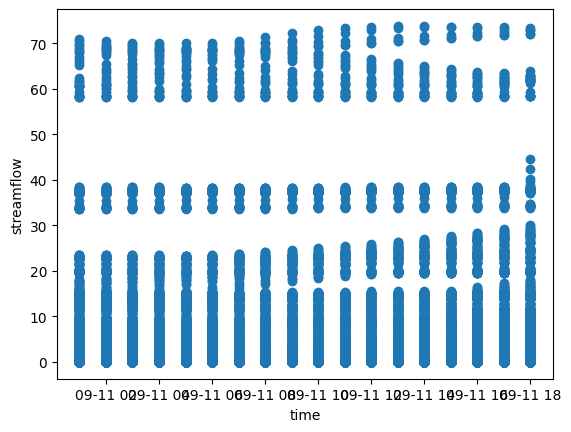

In [9]:
%%time
data = dd.read_parquet(
    "../data/parquet_10000_featureId_pyarrow_snappy.parquet"
    , storage_options={"anon": True}
    )
data
#%time data.loc[slice(None), int('101')]

#result = data.shape[0].compute()
result = data.compute()
result

r_xa = result.to_xarray()
r_xa
r_xa.plot.scatter("time","streamflow")
